In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout,TimeDistributed,Bidirectional
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import f1_score

In [2]:
# I used Google Chrome whilst working in Google Colab so I was able to complete this step by recieving the authorisation code after logging into my gmail account.
# Users may need to also use Google Chrome to run this code and connect via the browser to your gmail when prompted.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the dataset

In [3]:
from google.colab import files
import io
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']), header=None)

In [5]:
#df = pd.read_csv('dataset.csv', header=None)

df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (ETH)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Ignore']

# Preprocessing steps 
##### (Explained in the workbook titled 'Exploratory Data Analysis & Preprocessing)

In [6]:
df['Open Date'] = pd.to_datetime(df['Open Time'], unit='ms')

In [7]:
df['Close Date'] = pd.to_datetime(df['Close Time'], unit='ms')

In [8]:
df['Close Date'] = df['Close Date'].dt.normalize()

In [9]:
df.drop(['Open Time', 'Close Time'], axis=1, inplace=True)

In [10]:
df.drop(['Ignore', 'Volume (ETH)', 'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [11]:
df.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [12]:
df.set_index('Close Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-08-17,301.13,312.18,298.00,302.00,2.154655e+06
2017-08-18,302.00,311.79,283.94,293.96,2.858947e+06
2017-08-19,293.31,299.90,278.00,290.91,6.200226e+05
2017-08-20,289.41,300.53,282.85,299.10,7.428479e+05
2017-08-21,299.10,346.52,294.60,323.29,1.689472e+06


In [13]:
columns = df.columns.tolist()
columns = columns[-1:] + columns[:-1]
df = df[columns]

In [14]:
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1412 non-null   float64
 1   Open    1412 non-null   float64
 2   High    1412 non-null   float64
 3   Low     1412 non-null   float64
 4   Close   1412 non-null   float64
dtypes: float64(5)
memory usage: 66.2 KB


# Create classes

In [16]:
# create a column to indicate the price movement: 1 means the price has increased compared to the previous day, 0 means the price has decreased

movement = []

for i in range(len(df)-1):

  if df['Close'][i+1] < df['Close'][i]:
    movement.append(0)
  
  else:
    movement.append(1)


In [17]:
# datapoint 0 in the dataset (2017-08-17) will be dropped because there is no price information prior to this day so it can not be put into a class.
df.drop(df.index[0], inplace=True)
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29
2017-08-22,2.454426e+06,321.04,330.41,144.21,309.80


In [18]:
df['Price Movement'] = np.array(movement)

In [19]:
df

,Volume,Open,High,Low,Close,Price Movement
Close Date,,,,,,
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96,0
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91,0
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10,1
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29,1
2017-08-22,2.454426e+06,321.04,330.41,144.21,309.80,0
...,...,...,...,...,...,...
2021-06-24,1.377800e+09,1967.95,2036.61,1884.79,1989.52,1
2021-06-25,1.612557e+09,1989.53,2019.99,1791.22,1808.82,0
2021-06-26,1.478551e+09,1808.97,1852.80,1717.32,1829.64,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1411 entries, 2017-08-18 to 2021-06-28
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Volume          1411 non-null   float64
 1   Open            1411 non-null   float64
 2   High            1411 non-null   float64
 3   Low             1411 non-null   float64
 4   Close           1411 non-null   float64
 5   Price Movement  1411 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 77.2 KB


# Split dataset into training and testing datasets

#### I will now split the timeseries into training and test sets, before I scale it to prevent data leakage. https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/
#### I no longer need to create a validation set as model selection is complete 
#### 74.15% of the data will be used for training and the remaining 25.85% will be used as the test set

In [21]:
split = int(len(df)*0.7415)

training_set = df[:split]      
test_set = df[split:]          

In [22]:
print('Training: ', training_set.shape, '\nTest: ', test_set.shape)

Training:  (1046, 6) 
Test:  (365, 6)


# I will check how imbalanced the classes are in each of the datasets' target vectors. 
###I am following a Keras tutorial on how to check for and deal with imbalanced class sizes when training neural networks for classification tasks:
https://keras.io/examples/structured_data/imbalanced_classification/


In [23]:
print('TRAINING SET\n', 'Count:\n', training_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',training_set['Price Movement'].value_counts(normalize=True))
print('\nTESTING SET\n', 'Count:\n', test_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',test_set['Price Movement'].value_counts(normalize=True))


TRAINING SET
 Count:
 0    532
1    514
Name: Price Movement, dtype: int64 

Relative Frequencies:
 0    0.508604
1    0.491396
Name: Price Movement, dtype: float64

TESTING SET
 Count:
 1    213
0    152
Name: Price Movement, dtype: int64 

Relative Frequencies:
 1    0.583562
0    0.416438
Name: Price Movement, dtype: float64


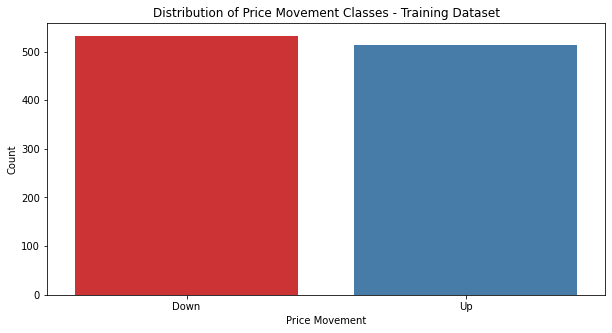

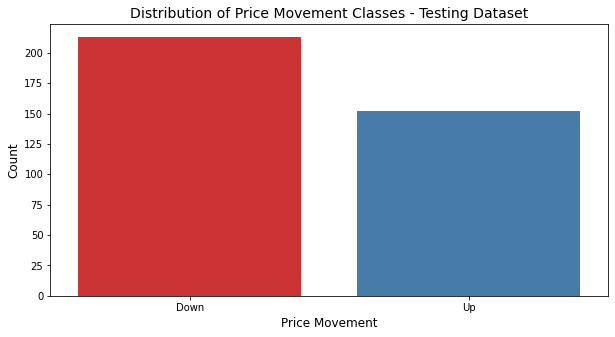

In [24]:
plt.figure(figsize = (10, 5))
sns.barplot(x = ['Down', 'Up'], y= training_set['Price Movement'].value_counts(), palette='Set1')
plt.title('Distribution of Price Movement Classes - Training Dataset')
plt.xlabel("Price Movement")
plt.ylabel("Count")
plt.show()

plt.figure(figsize = (10, 5))
sns.barplot(x = ['Down', 'Up'], y= test_set['Price Movement'].value_counts(), palette='Set1')
plt.title('Distribution of Price Movement Classes - Testing Dataset', fontsize=14)
plt.xlabel("Price Movement", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# Split the data into X and y variables

In [25]:
# the x values will contain all the features in the dataset and the y value will contain only the target feature to predict (Close Price) 

X_training = (training_set.iloc[:, :-1]).values.reshape(training_set.shape[0],training_set.shape[1]-1)
y_training = (training_set.iloc[:, -1]).values.reshape(training_set.shape[0],1)

print(X_training.shape, y_training.shape)

X_testing = (test_set.iloc[:, :-1]).values.reshape(test_set.shape[0],test_set.shape[1]-1)
y_testing = (test_set.iloc[:, -1]).values.reshape(test_set.shape[0],1)

print(X_testing.shape, y_testing.shape)

(1046, 5) (1046, 1)
(365, 5) (365, 1)


# Normalisation

#### The values need to be scaled to between 0 and 1 so I will use MinMaxScaler from scikit-learn to do this.
#### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [26]:
Xscaler = MinMaxScaler(feature_range=(0,1))
yscaler = MinMaxScaler(feature_range=(0,1))

X_train = Xscaler.fit_transform(X_training)
y_train = yscaler.fit_transform(y_training)

X_test = Xscaler.fit_transform(X_testing)
y_test = yscaler.fit_transform(y_testing)

## Prepare data for multi-step LSTM
##### source code: https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [27]:
# stack the data horizontally

train_stacked = np.hstack((X_train, y_train))
print ("Stacked Training Data Shape: " , train_stacked.shape)

test_stacked = np.hstack((X_test, y_test))
print ("Stacked Test Data Shape: " , test_stacked.shape)

Stacked Training Data Shape:  (1046, 6)
Stacked Test Data Shape:  (365, 6)


In [28]:
# create sequences (n_steps_in = input timesteps, n_steps_out = output timesteps)

def create_sequences(sequences, n_steps_in, n_steps_out):
 X, y = [], []

 for i in range(len(sequences)):

  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1

  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break

  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

   

In [29]:
# choose a number of time steps 
n_steps_in, n_steps_out = 14, 14

# run function
X_train, y_train = create_sequences(train_stacked, n_steps_in, n_steps_out)
print ("X train sequences: " , X_train.shape, "y train sequences" , y_train.shape)            

X_test, y_test = create_sequences(test_stacked, n_steps_in, n_steps_out)
print ("X test sequences: " , X_test.shape, "y test sequences" , y_test.shape)      

X train sequences:  (1020, 14, 5) y train sequences (1020, 14)
X test sequences:  (339, 14, 5) y test sequences (339, 14)


# **1. Model Building**


#### I will first load the optimised model.

In [30]:
baseline_cf = load_model('/content/drive/My Drive/Classification model/classification_model')
baseline_cf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 14, 20)            4160      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 20)            6560      
_________________________________________________________________
dropout (Dropout)            (None, 14, 20)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 14, 20)            6560      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 20)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 14, 20)            6560      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 20)            0

#### I will train and test the baseline model 5 times to get a list of accuracy scores to use later for statistical comparison. I will report the average test score here.
https://github.com/yanghaocsg/keras_lstm/wiki/chapter-7.1-Evaluating-LSTM-Models-Robustly

In [33]:
acc_list = []
f1_list = []

y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  baseline_cf.fit(X_train , y_train , epochs=100 , verbose=0 ,shuffle=False)    

  # generate the test predictions and calculate the scores

  test_pred = baseline_cf.predict(X_test)

  test_loss, test_accuracy = baseline_cf.evaluate(X_test, y_test, verbose = 0)

  test_pred = test_pred.astype(int).reshape(-1)
  y_test_flat = y_test.astype(int).reshape(-1)

  f1_result = f1_score(y_test_flat, test_pred, average='micro')
  print('Test Accuracy: ', float('%.3g' % test_accuracy)*100)

  acc_list.append(test_accuracy)
  f1_list.append(f1_result)

print('\nBaseline Classification BiLSTM Model -- \nAverage Test Accuracy: ', float('%.3g' % np.mean(acc_list))*100, 
      ' ||  Average Test F1 Score: ', float('%.3g' % np.mean(f1_list)))



Training Number  0
Test Accuracy:  44.7

Training Number  1
Test Accuracy:  51.9

Training Number  2
Test Accuracy:  54.300000000000004

Training Number  3
Test Accuracy:  56.10000000000001

Training Number  4
Test Accuracy:  54.900000000000006

Baseline Classification BiLSTM Model -- 
Average Test Accuracy:  52.400000000000006  ||  Average Test F1 Score:  0.409


In [36]:
# saving the accuracy scores of the model to compare against the models with different inputs in a statistical test

baselineScores_class = pd.DataFrame(acc_list)
baselineScores_class.to_csv('/content/drive/My Drive/Classification model/baselineScores_classModel.csv', index=False)